# Velocities plots

Loads adjusted data and then runs various plots for velocities, mean currents, and residual flows.

## Imports

Necessary modules for analysis.

In [2]:
# import modules

import xarray as xr
import cmocean
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [3]:
# import data

adcp = 'Slope'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/adj/adj_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/adj/adj_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]
    
#print(ds[0].uorig[:,0])

In [4]:
# extract plotting variables

t_stamp = ds[0].t_stamp
depth = ds[0].depth.values
d = len(depth)
start_date = ds[0].start_date
end_date = ds[0].end_date

# get WKB scale for site specific depth range

scaling_array = np.load('../project/archive/N2/scaling_array.npy')
GM_depths = scaling_array[0]                                 # depths range from -4 to -980 metres
GM_scale = scaling_array[1]
int_scale = np.interp(depth,-GM_depths,GM_scale)

## Comparison plots

<IPython.core.display.Javascript object>


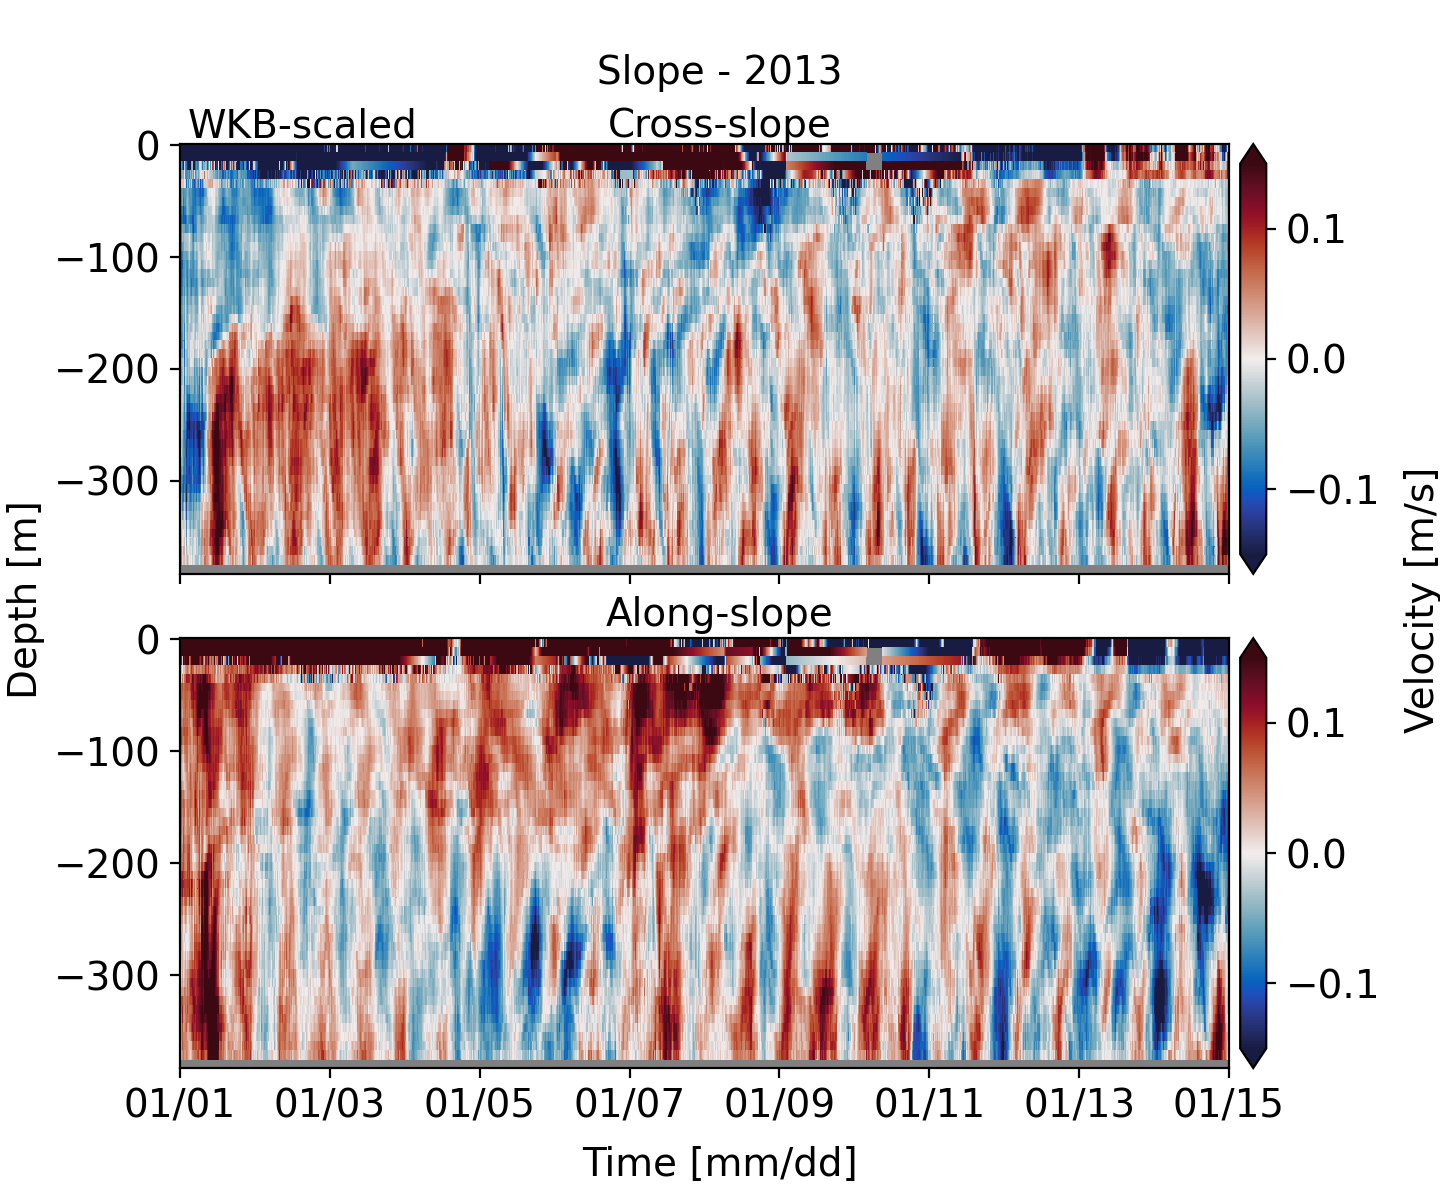

In [6]:
# plot adjusted velocity data

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(ds[i].uorig[:,j].values / np.sqrt(int_scale[j]))          # list[depth][frequency]
        v_WKB_temp.append(ds[i].vorig[:,j].values / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)

fig, (ax0,ax1) = plt.subplots(2,1, figsize=(7.2,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
fig.text(0.5, 0.93, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.975, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.02, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.21, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = -0.15
    vmax = 0.15
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = -0.2
    vmax = 0.2
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax,shading='auto')
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax,shading='auto')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
    
date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)
if adcp == 'Axis55' and t_stamp == '2017':
    ax1.set_xlim(f'{t_stamp}-12-15',f'{t_stamp}-12-31')
else:
    ax1.set_xlim(f'{t_stamp}-01-01',f'{t_stamp}-01-15')
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/vel_plots/vel_{adcp}_{t_stamp}.pdf',format='pdf')

<IPython.core.display.Javascript object>


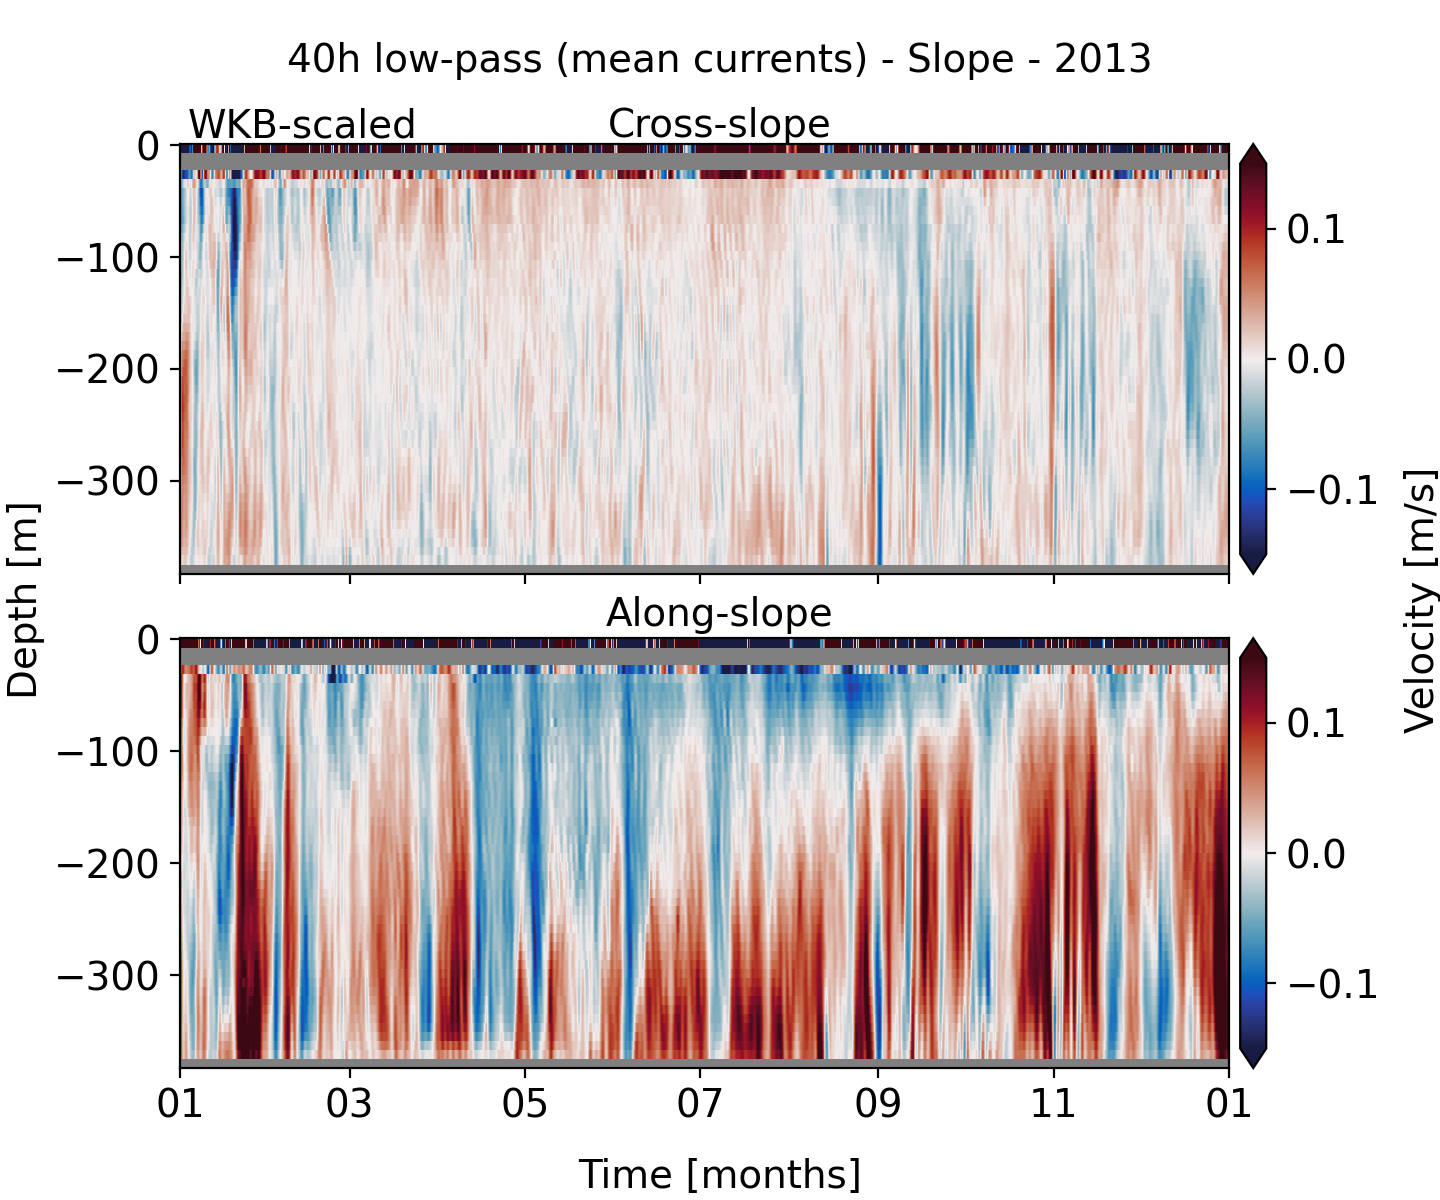

In [7]:
# plot mean current data

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(ds[i].ulp[:,j].values / np.sqrt(int_scale[j]))         # list[depth][frequency]
        v_WKB_temp.append(ds[i].vlp[:,j].values / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)

# plot mean current data

fig, (ax0,ax1) = plt.subplots(2,1, figsize=(7.2,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
fig.text(0.5, 0.94, f'40h low-pass (mean currents) - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.975, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.21, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = -0.15
    vmax = 0.15
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = -0.04
    vmax = 0.04
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
    
date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/vel_plots/lp_{adcp}_{t_stamp}.pdf',format='pdf')

<IPython.core.display.Javascript object>


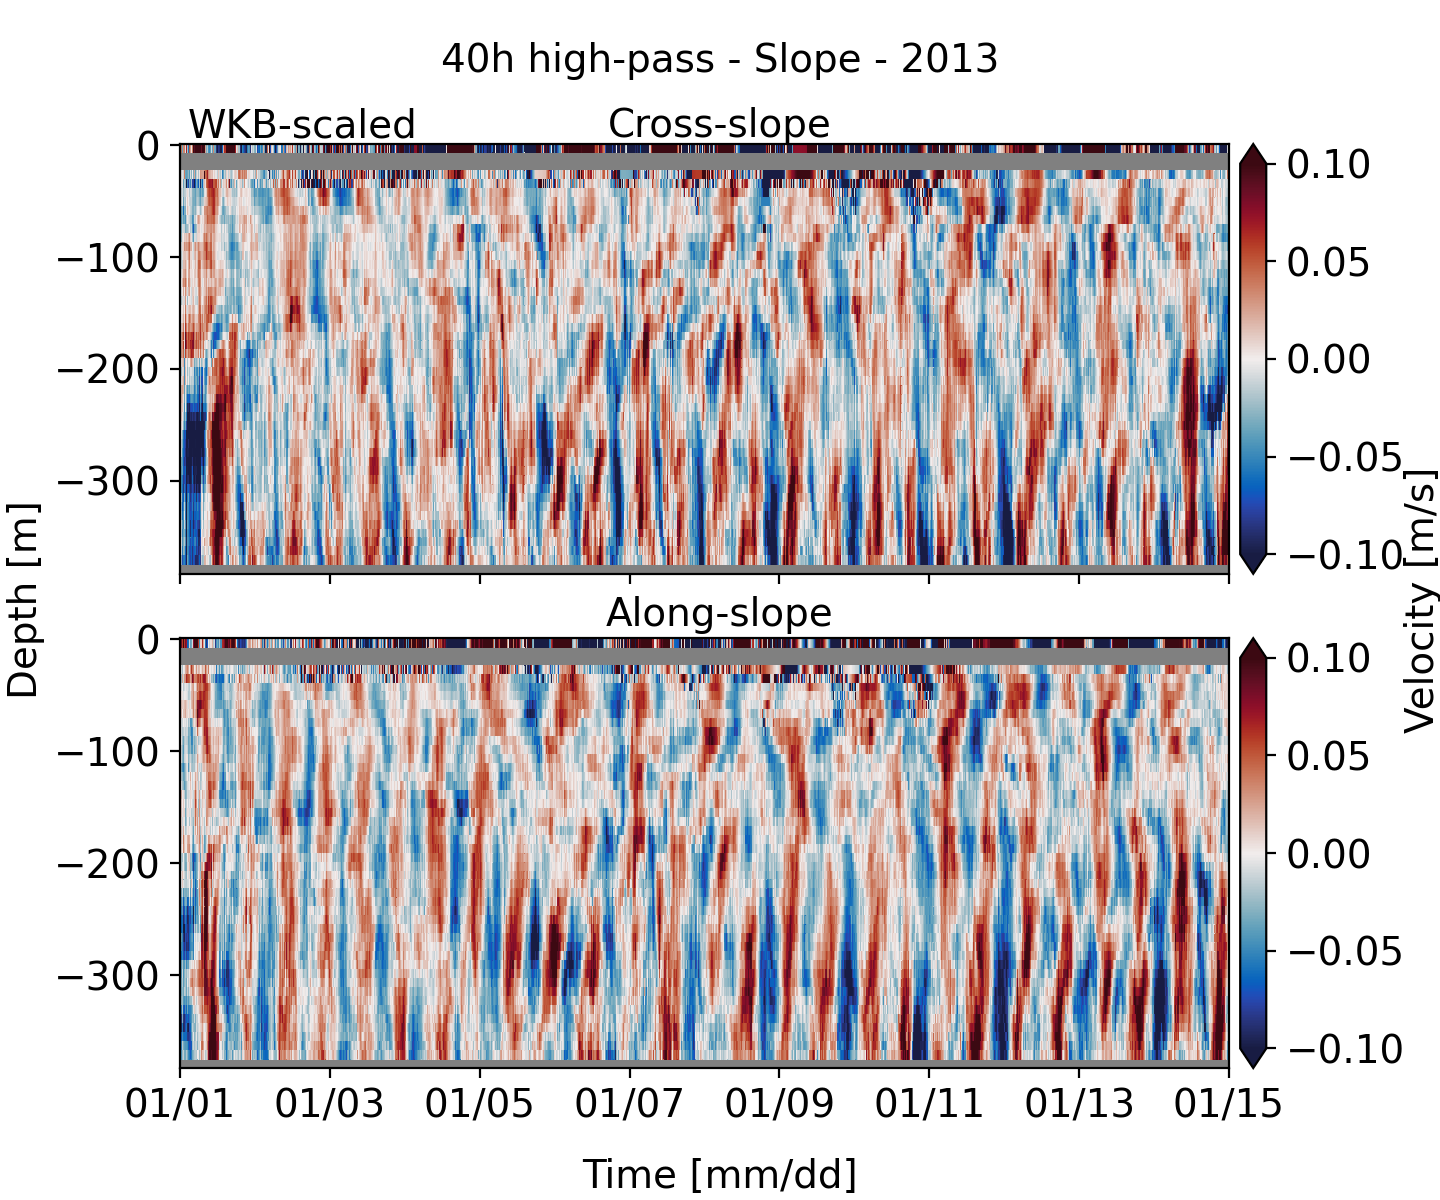

In [8]:
# plot residual flow data

# get residual flow data

uhp,vhp = [],[]
for i in range(n_seg):
    uhp_seg = ds[i].uorig - ds[i].ulp
    uhp.append(np.asarray(uhp_seg.values))
    vhp_seg = ds[i].vorig - ds[i].vlp
    vhp.append(np.asarray(vhp_seg.values)) 

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(uhp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
        v_WKB_temp.append(vhp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)
    
# plot
    
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(7.2,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
fig.text(0.5, 0.94, f'40h high-pass - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.975, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.21, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = -0.1
    vmax = 0.1
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = -0.2
    vmax = 0.2
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)
if adcp == 'Axis55' and t_stamp == '2017':
    ax1.set_xlim(f'{t_stamp}-12-15',f'{t_stamp}-12-31')
else:
    ax1.set_xlim(f'{t_stamp}-01-01',f'{t_stamp}-01-15')
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/vel_plots/hp_{adcp}_{t_stamp}.pdf',format='pdf')

## Band-filtered velocities

In [ ]:
# choose frequency band

ubp,vbp = [],[]   # empty lists for filtered data
f_band = 'Semidiurnal'                         # Diurnal, Inertial, Semidiurnal, Continuum

for i in range(n_seg):
    d = ds[i].d
    t = len(ds[i].t_seg)
    fs = 1.111e-3                               # samples per SECOND for entire time series
    if f_band == 'Inertial':
        Wn = [1.35e-5,2.00e-5]                              # cut-off frequencies
    elif f_band == 'Diurnal':
        Wn = [0.90e-5,1.40e-5]
    elif f_band == 'Semidiurnal':
        Wn = [2.00e-5,2.50e-5]
    elif f_band == 'Subdiurnal':
        Wn = [2.00e-6,0.9e-5]
    elif f_band == 'Continuum':
        Wn = [7.00e-5,2.00e-4]
    sos = sig.butter(8, Wn,'bandpass', fs=fs, output='sos')   # digital butterworth filter
    w,h = sig.sosfreqz(sos)                      # to plot filter response

    ubp_temp = np.empty([t,d])                  # empty array for low-pass filtered u values
    vbp_temp = np.empty([t,d])                  # empty array for low-pass filtered v values

    for j in range(d):                                 # loop for filtered and residual velocities
        ufilt = np.copy(ds[i].uorig[:,j].values)       # copy unfiltered array
        ubp_temp[:,j] = sig.sosfiltfilt(sos, ufilt)    # apply band pass filter

        vfilt = np.copy(ds[i].vorig[:,j].values)       # repeat for v
        vbp_temp[:,j] = sig.sosfiltfilt(sos, vfilt)

    ubp.append(ubp_temp)
    vbp.append(vbp_temp)

In [ ]:
# plot filter response

#plt.semilogx(w*fs/(2*np.pi),abs(h))

In [ ]:
# plot bandpass current data

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(ubp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
        v_WKB_temp.append(vbp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)

fig, (ax0,ax1) = plt.subplots(2,1, figsize=(7.2,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
fig.text(0.5, 0.94, f'Band-pass ({f_band}) - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.975, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.21, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
    if f_band == 'Inertial':
        vmin = -0.025
        vmax = 0.025
    elif f_band == 'Diurnal':
        vmin = -0.025
        vmax = 0.025
    elif f_band == 'Semidiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Subdiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Continuum':
        vmin = -0.025
        vmax = 0.025
    
elif adcp == 'Axis55' or adcp == 'Axis75':
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)
    if f_band == 'Inertial':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Diurnal':
        vmin = -0.1
        vmax = 0.1
    elif f_band == 'Semidiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Subdiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Continuum':
        vmin = -0.025
        vmax = 0.025

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax)
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax)

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
    
date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)
if adcp == 'Axis55' and t_stamp == '2017':
    ax1.set_xlim(f'{t_stamp}-12-15',f'{t_stamp}-12-31')
else:
    ax1.set_xlim(f'{t_stamp}-01-01',f'{t_stamp}-01-15')
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/vel_plots/bp_{f_band}_{adcp}_{t_stamp}.pdf',format='pdf')